In [1]:
import sys
import json
import logging
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, IBMQ, QuantumCircuit, QuantumRegister, transpile
from qiskit.ignis.mitigation.measurement import complete_meas_cal, MeasurementFilter
from qiskit.providers.ibmq.runtime.utils import RuntimeEncoder, RuntimeDecoder
#from qiskit.providers.ibmq.runtime import UserMessenger

sys.path.append('..')
from main import make_step_circuits, run_forward_circuits, run_fisc, main
from pnp_ansatze import make_pnp_ansatz
from observables import plot_counts_with_curve
from trotter import trotter_step_circuits
from sequential_minimizer import IdealCost
from hamiltonian import schwinger_model, diagonalized_evolution

## Runtime job input

In [2]:
kwargs = {
    'num_sites': 2,
    'aJ': 1.,
    'am': 0.5,
    'omegadt': 0.2,
    'num_tsteps': 8,
    'tsteps_per_rqd': 2,
    'error_matrix': np.eye(4, dtype='f8'),
    'physical_qubits': None,
    'minimizer_shots': 4096,
    'forward_shots': 2 * 8192,
    'max_sweeps': 100
}

logging.getLogger('schwinger_rqd').setLevel(logging.INFO)

## Testing just the forward steps

2021-11-09 10:36:59,264: Running 8 circuits, 16384 shots per experiment, 8 experiments
2021-11-09 10:36:59,981: Forward circuit results returned


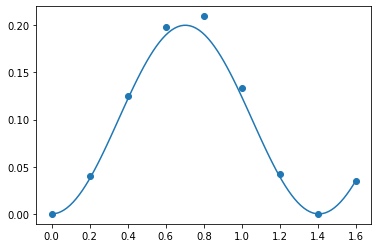

In [3]:
backend = Aer.get_backend('statevector_simulator')

num_sites = kwargs['num_sites']
aJ = kwargs['aJ']
am = kwargs['am']
omegadt = kwargs['omegadt']
num_tsteps = kwargs['num_tsteps']
physical_qubits = kwargs['physical_qubits']
error_matrix = kwargs['error_matrix']
forward_shots = kwargs['forward_shots']

_, state_labels = complete_meas_cal(qubit_list=list(range(num_sites)), qr=QuantumRegister(num_sites), circlabel='mcal')
error_mitigation_filter = MeasurementFilter(error_matrix, state_labels)

forward_step_circuits = make_step_circuits(num_sites, aJ, am, omegadt, backend, physical_qubits)

target_circuits = trotter_step_circuits(num_tsteps, forward_step_circuits, initial_state=None, measure=False)

counts_list = run_forward_circuits(target_circuits, backend, initial_layout=physical_qubits, shots=forward_shots, error_mitigation_filter=error_mitigation_filter)

plot_counts_with_curve(counts_list, num_sites, aJ, am, omegadt, num_tsteps, initial_state=None, num_toys=0)

## Testing one RQD step

In [4]:
backend = Aer.get_backend('qasm_simulator')

num_sites = kwargs['num_sites']
aJ = kwargs['aJ']
am = kwargs['am']
omegadt = kwargs['omegadt']
tsteps_per_rqd = kwargs['tsteps_per_rqd']
max_sweeps = kwargs['max_sweeps']
minimizer_shots = kwargs['minimizer_shots']
forward_shots = kwargs['forward_shots']
physical_qubits = kwargs['physical_qubits']
error_matrix = kwargs['error_matrix']

_, state_labels = complete_meas_cal(qubit_list=list(range(num_sites)), qr=QuantumRegister(num_sites), circlabel='mcal')
error_mitigation_filter = MeasurementFilter(error_matrix, state_labels)

forward_step_circuits = make_step_circuits(num_sites, aJ, am, omegadt, backend, physical_qubits)
if not backend.configuration().simulator:
    sim_forward_step_circuits = make_step_circuits(num_sites, aJ, am, omegadt, Aer.get_backend('statevector_simulator'), physical_qubits)

if num_sites == 2:
    approximator = make_pnp_ansatz(
        num_qubits=num_sites,
        num_layers=num_sites // 2,
        initial_x_positions=[0])
elif num_sites == 4:
    approximator = make_pnp_ansatz(
        num_qubits=num_sites,
        num_layers=num_sites // 2,
        initial_x_positions=[1, 2],
        structure=[(1, 2), (0, 1), (2, 3)],
        first_layer_structure=[(0, 1), (2, 3)])

target_circuits = trotter_step_circuits(tsteps_per_rqd, forward_step_circuits, measure=False)

forward_counts = run_forward_circuits(target_circuits, backend, initial_layout=physical_qubits, shots=forward_shots, error_mitigation_filter=error_mitigation_filter)

compiler_circuit = target_circuits[-1].compose(approximator.inverse(), inplace=False)

if backend.configuration().simulator:
    ideal_cost = IdealCost(compiler_circuit)
else:
    targets = trotter_step_circuits(tsteps_per_rqd, sim_forward_step_circuits, measure=False)
    ideal_cost = IdealCost(targets[-1].compose(approximator.inverse(), inplace=False))
    
def callback_publish_sweep_result(minimizer, arg):
    sweep_result = {
        'rqd_step': 0,
        'isweep': arg['isweep'],
        'param_val': arg['sweep_param_val'],
        'cost': arg['sweep_cost'], 
        'total_shots': arg['current_shots'] + arg['sweep_shots']
    }
    print(sweep_result)

optimal_params = run_fisc(compiler_circuit, backend, physical_qubits, max_sweeps, minimizer_shots, error_mitigation_filter, ideal_cost, callback_publish_sweep_result)

2021-11-09 10:37:00,357: Running 2 circuits, 16384 shots per experiment, 2 experiments
2021-11-09 10:37:00,508: Forward circuit results returned
2021-11-09 10:37:00,635: Starting minimize() with initial parameter values [0.78539816 0.78539816]
2021-11-09 10:37:00,636: Sweep 0 with strategy largest-drop - current cost 1.0 current shots 0
2021-11-09 10:37:00,637: largest drop: Calculating cost sections for all parameters
2021-11-09 10:37:00,638: calculate cost section over parameters [0, 1]
2021-11-09 10:37:00,646: run circuits: Running 24 experiments, 256 shots each
2021-11-09 10:37:01,973: largest drop: Stepping in direction 0
2021-11-09 10:37:01,974: calculate cost section over parameters 0
2021-11-09 10:37:01,982: run circuits: Running 12 experiments, 4096 shots each
2021-11-09 10:37:02,228: Sweep 1 with strategy largest-drop - current cost 0.013501363036276026 current shots 55296
2021-11-09 10:37:02,229: largest drop: Calculating cost sections for all parameters
2021-11-09 10:37:02,

{'rqd_step': 0, 'isweep': 0, 'param_val': array([1.2163093 , 0.78539816]), 'cost': 0.013501363036276026, 'total_shots': 55296}


2021-11-09 10:37:02,456: largest drop: Stepping in direction 1
2021-11-09 10:37:02,457: calculate cost section over parameters 1
2021-11-09 10:37:02,463: run circuits: Running 12 experiments, 4096 shots each
2021-11-09 10:37:02,712: Sweep 2 with strategy largest-drop - current cost 0.00042944716547452244 current shots 107520
2021-11-09 10:37:02,713: largest drop: Calculating cost sections for all parameters
2021-11-09 10:37:02,714: calculate cost section over parameters [0]
2021-11-09 10:37:02,719: run circuits: Running 12 experiments, 256 shots each


{'rqd_step': 0, 'isweep': 1, 'param_val': array([1.2163093 , 1.13141338]), 'cost': 0.00042944716547452244, 'total_shots': 107520}


2021-11-09 10:37:02,878: largest drop: Stepping in direction 0
2021-11-09 10:37:02,881: calculate cost section over parameters 0
2021-11-09 10:37:02,888: run circuits: Running 12 experiments, 4096 shots each
2021-11-09 10:37:03,113: Minimization converged by cost update


{'rqd_step': 0, 'isweep': 2, 'param_val': array([1.2058836 , 1.13141338]), 'cost': 0.00037953082964015117, 'total_shots': 159744}


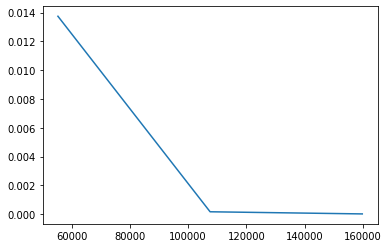

In [5]:
plt.plot(ideal_cost.shots_sweep, ideal_cost.costs_sweep)

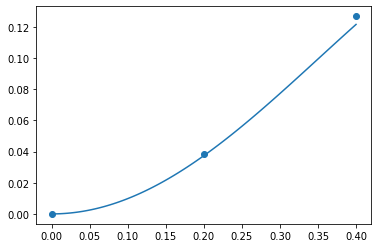

In [6]:
plot_counts_with_curve(forward_counts, num_sites, aJ, am, omegadt, tsteps_per_rqd, initial_state=None, num_toys=0)

vacuum_state = np.zeros(2 ** num_sites, dtype=np.complex128)
vacuum_state_index = 0
for j in range(0, num_sites, 2):
    vacuum_state_index += (1 << j)
vacuum_state[vacuum_state_index] = 1.

hamiltonian = schwinger_model(num_sites, aJ, am)
_, statevectors = diagonalized_evolution(hamiltonian, vacuum_state, omegadt * tsteps_per_rqd)
plot_counts_with_curve(forward_counts_2, num_sites, aJ, am, omegadt, tsteps_per_rqd, initial_state=statevectors[:, -1], num_toys=0)

plot_counts_with_curve(forward_counts + forward_counts_2, num_sites, aJ, am, omegadt, tsteps_per_rqd * 2, initial_state=None, num_toys=0)

## Testing the main program

In [7]:
class UserMessenger:
    """Base class for handling communication with program users.

    This class can be used when writing a new Qiskit Runtime program.
    """
    
    def __init__(self):
        self.interim_results = []

    def publish(
            self,
            message,
            encoder=RuntimeEncoder,
            final=False
    ):
        """Publish message.

        You can use this method to publish messages, such as interim and final results,
        to the program user. The messages will be made immediately available to the user,
        but they may choose not to receive the messages.

        The `final` parameter is used to indicate whether the message is
        the final result of the program. Final results may be processed differently
        from interim results.

        Args:
            message: Message to be published. Can be any type.
            encoder: An optional JSON encoder for serializing
            final: Whether the message being published is the final result.
        """
        # pylint: disable=unused-argument
        # Default implementation for testing.
        self.interim_results.append(message)

In [8]:
user_messenger = UserMessenger()
serialized_inputs = json.dumps(kwargs, cls=RuntimeEncoder)
deserialized_inputs = json.loads(serialized_inputs, cls=RuntimeDecoder)

forward_counts, optimal_params_list = main(backend, user_messenger, **deserialized_inputs)

2021-11-09 10:37:03,455: Starting RQD step 0
2021-11-09 10:37:03,632: Running 2 circuits, 16384 shots per experiment, 2 experiments
2021-11-09 10:37:03,807: Forward circuit results returned
2021-11-09 10:37:03,909: Starting minimize() with initial parameter values [0.78539816 0.78539816]
2021-11-09 10:37:03,910: Sweep 0 with strategy largest-drop - current cost 1.0 current shots 0
2021-11-09 10:37:03,911: largest drop: Calculating cost sections for all parameters
2021-11-09 10:37:03,911: calculate cost section over parameters [0, 1]
2021-11-09 10:37:03,921: run circuits: Running 24 experiments, 256 shots each
2021-11-09 10:37:04,203: largest drop: Stepping in direction 0
2021-11-09 10:37:04,210: calculate cost section over parameters 0
2021-11-09 10:37:04,218: run circuits: Running 12 experiments, 4096 shots each
2021-11-09 10:37:04,489: Sweep 1 with strategy largest-drop - current cost 0.011108539040339871 current shots 55296
2021-11-09 10:37:04,490: largest drop: Calculating cost sec

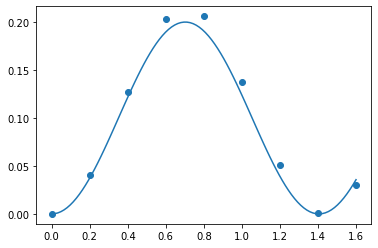

In [9]:
plot_counts_with_curve(forward_counts, num_sites, aJ, am, omegadt, num_tsteps, initial_state=None, num_toys=0)

## Testing reentry

In [10]:
resume_rqd_step = -1
resume_from = {}

for message in user_messenger.interim_results:
    if 'optimal_params' in message:
        resume_from['optimal_params'] = message['optimal_params']
        resume_from['rqd_step'] = message['rqd_step'] + 1
        resume_rqd_step = message['rqd_step'] + 1
        
    if message['rqd_step'] == resume_rqd_step:
        if 'forward_counts' in message:
            resume_from['forward_counts'] = message['forward_counts']
        
        if 'isweep' in message and message['isweep'] == 2:
            resume_from['current_sweep'] = message['isweep'] + 1
            resume_from['param_val'] = message['param_val']
            resume_from['current_cost'] = message['cost']
            resume_from['total_shots'] = message['total_shots']
            break
            
kwargs['resume_from'] = resume_from
            
user_messenger = UserMessenger()
serialized_inputs = json.dumps(kwargs, cls=RuntimeEncoder)
deserialized_inputs = json.loads(serialized_inputs, cls=RuntimeDecoder)

forward_counts_res, optimal_params_list_res = main(backend, user_messenger, **deserialized_inputs)

2021-11-09 10:37:22,745: Starting RQD step 1
2021-11-09 10:37:22,867: Resuming minimization from parameter values [1.09374632 0.17721932]
2021-11-09 10:37:22,868: Sweep 3 with strategy largest-drop - current cost 0.0007060130853665525 current shots 159744
2021-11-09 10:37:22,869: largest drop: Calculating cost sections for all parameters
2021-11-09 10:37:22,869: calculate cost section over parameters [0, 1]
2021-11-09 10:37:22,879: run circuits: Running 24 experiments, 256 shots each
2021-11-09 10:37:23,104: largest drop: Stepping in direction 1
2021-11-09 10:37:23,106: calculate cost section over parameters 1
2021-11-09 10:37:23,113: run circuits: Running 12 experiments, 4096 shots each
2021-11-09 10:37:23,521: Sweep 4 with strategy largest-drop - current cost -1.362589810693926e-05 current shots 215040
2021-11-09 10:37:23,522: largest drop: Calculating cost sections for all parameters
2021-11-09 10:37:23,523: calculate cost section over parameters [0]
2021-11-09 10:37:23,527: run cir

ValueError: x and y must be the same size

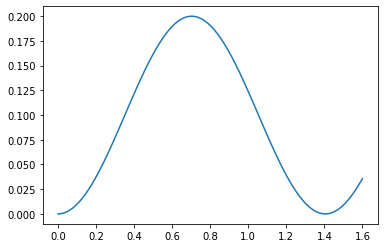

In [11]:
plot_counts_with_curve(forward_counts + forward_counts_res, num_sites, aJ, am, omegadt, num_tsteps, initial_state=None, num_toys=0)